In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import torch
import torch.nn as nn
from torch.distributions import Normal, MixtureSameFamily, Categorical, Independent, transforms, StudentT, Laplace
import torch.distributions as td
import matplotlib.pyplot as plt
import numpy as np
import tqdm.notebook as tqdm

from scem import ebm, stein, kernel, util, gen


def score(p, x):
    x = x.clone().requires_grad_()
    s = torch.autograd.grad(p.log_prob(x).sum(), [x])[0]
    return s

class SLaplace(Laplace):
    
    def score(self, x):
        return -torch.sign(x - self.loc) / self.scale

class SStudentT(StudentT):
    
    def score(self, x):
        d = self.df
        m  = self.loc
        s  = self.scale
        z = (x - m)/s
        return - (d + 1) * z / (d + z**2) / s

class SNormal(Normal):
    
    def score(self, x):
        
        return -( x - self.mean ) / self.scale**2
    
    def div_score(self, x):
        
        return - 1. / self.scale**2 * torch.ones_like(x).sum(-1)
        

class SGMM(MixtureSameFamily):
    
    def score(self, x):
        
        logpx_z = self.component_distribution.log_prob(x[...,None,:])
        logpxz  = logpx_z + self.mixture_distribution.probs.log()
        logpx   = torch.logsumexp(logpxz, -1)
        
        pz_x = (logpxz - logpx[...,None]).exp()

        dxlogpx_z = self.component_distribution.base_dist.score(x[...,None,:])
        s = (dxlogpx_z * pz_x[...,None]).sum(-2)

        return s
    
grid = torch.linspace(-3.0,3.0,1000)[:,None]

Dx = 1
kx = kernel.KGauss(torch.tensor([1.0]))

In [3]:
def get_noise_plot(q, p, plot=True, nnoise= 20, nsample = 500):
    
    
    noises = np.logspace(-1,1,nnoise)
    p_ksds = []
    p_ksd_vars = []
    q_ksds = []
    q_ksd_vars = []
    q_ts = []
    p_ts = []
    q_ksd_trues = []
    q_ksd_var_trues = []
     
    p_ksd_trues = []
    p_ksd_var_trues = []


    x = q.sample([nsample])
    
    for n in tqdm.tqdm(noises):
        y = x+td.Normal(0,1).sample(x.shape)*n
        
#         y = x * n

        q_ksd_true, q_ksd_var_true = stein.ksd_ustat(y, q.score, kx, return_variance=True)
        p_ksd_true, p_ksd_var_true = stein.ksd_ustat(y, p.score, kx, return_variance=True)

        p_t, p_ksd, p_ksd_var = stein.opt_t_ksd_ustat(y, p.score, kx, return_variance=True)
        q_t, q_ksd, q_ksd_var = stein.opt_t_ksd_ustat(y, q.score, kx, return_variance=True)

        q_ksds += q_ksd.item(),
        p_ksds += p_ksd.item(),

        q_ksd_vars += q_ksd_var.item(),
        p_ksd_vars += p_ksd_var.item(),

        q_ksd_trues += q_ksd_true.item(),
        q_ksd_var_trues += q_ksd_var_true.item(),

        p_ksd_trues += p_ksd_true.item(),
        p_ksd_var_trues += p_ksd_var_true.item(),


        q_ts += q_t.item(),
        p_ts += p_t.item(),


    q_ksd_stds = np.sqrt(q_ksd_vars)
    q_ksd_stds[~np.isfinite(q_ksd_stds)] = 0
    p_ksd_stds = np.sqrt(p_ksd_vars)
    p_ksd_stds[~np.isfinite(p_ksd_stds)] = 0

    q_ksd_std_trues = np.sqrt(q_ksd_var_trues)
    q_ksd_std_trues[~np.isfinite(q_ksd_std_trues)] = 0
    
    p_ksd_std_trues = np.sqrt(p_ksd_var_trues)
    p_ksd_std_trues[~np.isfinite(p_ksd_std_trues)] = 0
    
    if not plot:
        return q_ksds, q_ksd_stds, p_ksds, p_ksd_stds, q_ksd_trues, q_ksd_std_trues, p_ksd_trues, p_ksd_std_trues
    
    fig, axes = plt.subplots(1,3,figsize=(10,1))

    ax = axes[0]
    ax.plot(grid, p.log_prob(grid).exp().numpy(), label="p");
    ax.plot(grid, q.log_prob(grid).exp().numpy(), label="q");
#     ax.legend()
    ax.set_title("density and score")

    ax = ax.twinx()
    ax.plot(grid, p.score(grid).detach(), ls='--')
    ax.plot(grid, q.score(grid).detach(), ls='--')
    ax.set_yticklabels([])
    
    ax = axes[1]
    ax.errorbar(noises,p_ksd_trues,yerr = p_ksd_std_trues, label="p") 
    ax.errorbar(noises,q_ksd_trues,yerr = q_ksd_std_trues, label="q")
    ax.hlines(0, min(noises), max(noises), 'k', ls=':')
#     ax.legend()
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$\epsilon$", labelpad=-2)
    ax.set_title(r"KSD$_k[q_\epsilon || \cdot]$")


    ax = axes[2]
    ax.errorbar(noises,p_ksds,yerr = p_ksd_stds*1, label="p") 
    ax.errorbar(noises,q_ksds,yerr = q_ksd_stds*1, label="q")
    ax.hlines(0, min(noises), max(noises), 'k', ls=':')
    ax.legend(frameon=False, loc="lower right", ncol=2)
    ax.set_xscale("log")
    ax.set_xlabel(r"$\epsilon$", labelpad=-2)
    ax.set_title(r"tm-KSD$_{\epsilon,k}[q || \cdot]$")
    
    return fig, axes

## Two Gaussians with mean shift

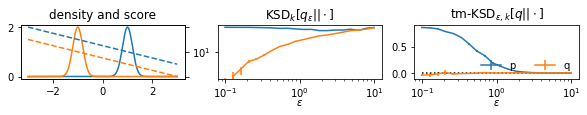

In [7]:
q = SNormal(torch.tensor([-1.0]),torch.ones(1)*0.2)
p = SNormal(torch.tensor([1.0]),torch.ones(1)*0.2)
get_noise_plot(q,p,True);

## Two Lapalces with mean shift

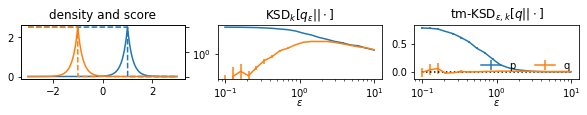

In [9]:
q = SLaplace(torch.tensor([-1.0]),torch.ones(1)*0.2)
p = SLaplace(torch.tensor([1.0]),torch.ones(1)*0.2)
get_noise_plot(q,p);

## Gaussian and mixture of Gaussians

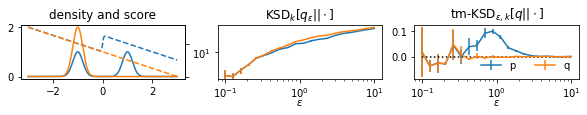

In [10]:
q = SNormal(torch.tensor([-1.0]),torch.ones(1)*0.2)
# mixture p
mixing = Categorical(probs = torch.tensor([0.5,0.5]))
component = Independent(SNormal(torch.tensor([-1,1.0])[:,None],torch.ones(1,1)*0.2), 1)
p = SGMM(mixing, component, 1)
fig, axes = get_noise_plot(q,p)

## Student T and mixture of Student T

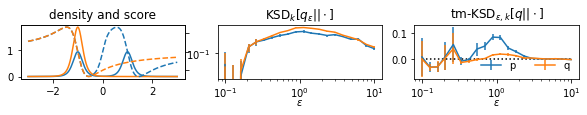

In [11]:
torch.random.manual_seed(123)
q = SStudentT(5, torch.tensor([-1.0]),torch.ones(1)*0.2)
# mixture p
mixing = Categorical(probs = torch.tensor([0.5,0.5]))
component = Independent(SStudentT(5, torch.tensor([-1,1.0])[:,None],torch.ones(1,1)*0.2), 1)
p = SGMM(mixing, component, 1)
get_noise_plot(q,p)
fig.savefig("../../litenet/figs/tmKSD_MoS.pdf", bbox_inches = 'tight', pad_inches = 0.01)

## Laplace and mixture of Laplaces

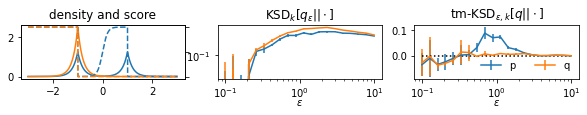

In [12]:
torch.random.manual_seed(123)
q = SLaplace(torch.tensor([-1.0]),torch.ones(1)*0.2)
# mixture p
mixing = Categorical(probs = torch.tensor([0.5,0.5]))
component = Independent(SLaplace(torch.tensor([-1,1.0])[:,None],torch.ones(1,1)*0.2), 1)
p = SGMM(mixing, component, 1)
fig, axes = get_noise_plot(q,p,nsample = 500)
fig.savefig("../../litenet/figs/tmKSD_MoL.pdf", bbox_inches = 'tight', pad_inches = 0.01)

## tm-KSD for component weight mismatch

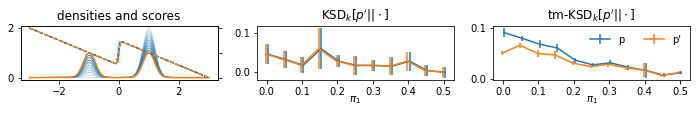

In [340]:
dist_name = 'MoG'
globals().update(np.load(f'tmKSD_mix_MoG.npz'))

fig, axes = plt.subplots(1,3,figsize=(12,1))
ax = axes[0]
ax1 = ax.twinx()


# mixture p
mixing = Categorical(probs = torch.tensor([0.5,0.5]))
component = Independent(SNormal(torch.tensor([-1.0,1.0])[:,None],torch.ones(1,1)*0.2), 1)
p = SGMM(mixing, component, 1)


for pi in pis:
    mixing = Categorical(probs = torch.tensor([pi,1-pi]))
    component = Independent(SNormal(torch.tensor([-1.0,1.0])[:,None],torch.ones(1,1)*0.2), 1)
    q = SGMM(mixing, component, 1)

    ax.plot(grid,q.log_prob(grid).exp(), 'C0', alpha = 0.2+float(pi*1.5), lw=1)

    ax1.plot(grid, q.score(grid).detach(), 'C0--', alpha = 0.2+float(pi*1.5), lw=1)
    ax1.set_yticklabels([])

ax.plot(grid,p.log_prob(grid).exp(), 'C1')
ax1.plot(grid, p.score(grid).detach(), 'C1--')

    

ax = axes[1]
ax.errorbar(pis+0.003, p_ksd_trues_0, yerr = p_ksd_std_trues_0)
ax.errorbar(pis-0.003, q_ksd_trues_0, yerr = q_ksd_std_trues_0)

ax = axes[2]
ax.errorbar(pis+0.003, max_p_ksds, yerr = max_p_ksd_stds)
ax.errorbar(pis-0.003, max_q_ksds, yerr = max_q_ksd_stds)
# plt.xscale("log")

axes[0].set_title("densities and scores")
axes[1].set_title("KSD$_k[p'||\cdot]$")
axes[2].set_title("tm-KSD$_k[p'||\cdot]$")
axes[2].legend(["p", "p'"], frameon=False, ncol=2)
axes[1].set_xlabel("$\pi_1$", labelpad=-3)
axes[2].set_xlabel("$\pi_1$", labelpad=-3)

fig.savefig(f"../../litenet/figs/tmKSD_mix_{dist_name}.pdf", bbox_inches = 'tight', pad_inches = 0.01)

## show why annealing noise may not work

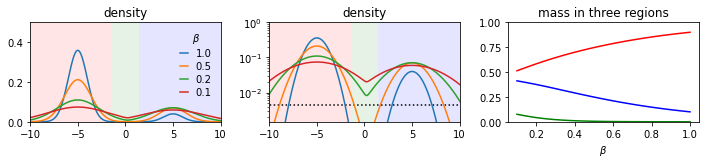

In [2589]:
q = SNormal(torch.tensor([-0.0]),torch.ones(1)*5)
# mixture p
mixing = Categorical(probs = torch.tensor([0.9,0.1]))
component = Independent(SNormal(torch.tensor([-5,5.0])[:,None],torch.ones(1,1)), 1)
p = SGMM(mixing, component, 1)

grid = torch.linspace(-20,20,1000)[:,None]
dx = (grid[1] - grid[0])

fig, axes = plt.subplots(1,3, figsize=(10,2), sharex=False)
ts = [1.0,0.5,0.2,0.1]
for t in ts:
# grid = torch.linspace(-10,10,100)[:,None]
    # plt.hist(x_q[:,0].numpy(), density=True, bins=np.linspace(-10,10,100))
    pt_x = p.log_prob(grid)*t
    pt_x = pt_x.exp() / pt_x.exp().sum() / dx
    axes[0].plot(grid, pt_x)
    axes[1].plot(grid, pt_x)
    
axes[1].set_yscale("log")
normpdf = Normal(0,1).log_prob(3).exp()
axes[1].set_ylim([normpdf/3,1])
axes[1].hlines(normpdf, -15, 15, "k", ls=":")
axes[0].set_xlim([-10,10])
axes[1].set_xlim([-10,10])

axes[0].legend(ts, ncol=1, handlelength=0.8, labelspacing=0.3, columnspacing=0.8, frameon=False, title=r"$\beta$")

ts = torch.linspace(0.1,1,20)

masses = torch.zeros(len(ts), 3)
x_thresh = 1.4


for ti, t in enumerate(ts):
# grid = torch.linspace(-10,10,100)[:,None]
    # plt.hist(x_q[:,0].numpy(), density=True, bins=np.linspace(-10,10,100))
    pt_x = p.log_prob(grid)*t
    pt_x = pt_x.exp() / pt_x.exp().sum() / (grid[1] - grid[0])
    
    masses[ti,0] = pt_x[grid[:,0] < -x_thresh].sum() * dx
    masses[ti,2] = pt_x[grid[:,0] > x_thresh].sum() * dx
    
    

masses[:,1] = 1 - masses.sum(-1)

colors = ['r','g','b']
for i in range(3):
    axes[2].plot(ts, masses[:,i], color = colors[i])
# axes[2].set_yscale("log")

for i in range(2):
    axes[i].fill_between([-10,-x_thresh],[1,1],[0,0], color="red", alpha=0.1, edgecolor=None)
    axes[i].fill_between([-x_thresh,x_thresh],[1,1],[0,0], color="green", alpha=0.1, edgecolor=None)
    axes[i].fill_between([x_thresh,10],[1,1],[0,0], color="blue", alpha=0.1, edgecolor=None)

plt.tight_layout()
axes[0].set_ylim([0,0.5])
axes[0].set_title("density")
axes[1].set_title("density")
axes[2].set_title("mass in three regions")
axes[2].set_xlabel(r"$\beta$")
axes[2].set_ylim(0,1)

fig.savefig("../../litenet/figs/mixture_temperature.pdf", bbox_inches = 'tight', pad_inches = 0.01)

## Improving SVGD with Langevin

In [130]:
device = torch.device("cuda:0")
q = SNormal(torch.tensor([.0], device=device),torch.ones(1, device=device)*1)
# mixture p
mixing = Categorical(probs = torch.tensor([0.7,0.3], device=device))
component = Independent(SNormal(torch.tensor([-5,5.0], device=device)[:,None],torch.ones(1,1, device=device)), 1)
p = SGMM(mixing, component, 1)

x = q.sample([1000])

kx = kernel.KGauss(torch.tensor([3.0], device=device))
# kx = kernel.BKIMQ()

def stein_grad(kx, samples, s, x, step_size = 1):
    score = s(samples)
    sg = (t * score[:,None,:] * kx.eval(samples, x)[...,None] + kx.gradX(samples, x)).mean(0) * step_size
    return sg

def stochastic_stein_grad(kx, samples, s, x, step_size=1, noise = 1):
    
    score = s(samples)
    sg = (t * score[:,None,:] * kx.eval(samples, x)[...,None] + kx.gradX(samples, x)).mean(0) * step_size
    lg = score * step_size * noise + torch.sqrt(2 * noise * step_size) * torch.randn_like(x)
    return sg + lg


def langevin_grad(kx, samples, s, x, step_size=1, noise = 1):
    
    score = s(samples)
    lg = score * step_size * noise + torch.sqrt(2 * noise * step_size) * torch.randn_like(x)
    return lg
    


def stein_grad_components(kx, samples, s, x, h ):
    a = (t * s(samples)[:,None,:] * kx.eval(samples, x)[...,None]).mean(0)
    b = ( kx.gradX(samples, x)).mean(0)
    return  a, b, a+b


def get_opt_sigma(samples, p, t):

    noises = torch.logspace(-2,2,30)
    ksds = []
    rnd = torch.randn_like(samples) 
    for n in noises:
        y = samples + rnd * n
        ksds += stein.ksd_ustat(y, lambda x: p.score(x) * t, kx, return_variance=False).item(),
    opt_n = noises[np.argmin(ksds)]
    plt.plot(ksds)
    return opt_n

In [ ]:
q = SNormal(torch.tensor([0.0], device=device),torch.ones(1, device=device)*1.0)
x = q.sample([1000]).to(device)

grad_a = []
grad_b = []
props = []
stein_grads = []
stds = []

t = 1
kx = kernel.KGauss(torch.tensor([1.], device=device))

for noise in tqdm.tqdm(torch.linspace(1,1,100)):
    for i in range(1000):
#         x = x + torch.randn_like(x, device=device) * noise
            
#         grad_x = stein_grad(kx, x, p.score, x)
        grad_x = stochastic_stein_grad(kx, x, p.score, x, step_size = 1, noise = noise)
#         grad_x = langevin_grad(kx, x, p.score, x, step_size = 0.1, noise = noise)


        x = x + 1 * grad_x
        
    stein_grads += grad_x.norm(dim=-1).mean().item(),
    props += (x>0).to(torch.float).mean().item(),
    stds += x.std().item(),
    
grid = torch.linspace(-20,20,1000, device=device)[:,None]
plt.hist(x[:,0].cpu().numpy(), density=True, bins=50)
pt_x = p.log_prob(grid)*t
pt_x = pt_x.exp() / pt_x.exp().sum() / (grid[1] - grid[0])
plt.plot(grid.cpu(), pt_x.cpu())

## Load results

waiting for results/DN_pi0.1_sigma1.0_noise1.0_mean10.0_is3000_spos_ntfixed_seed02.npz
waiting for results/DN_pi0.1_sigma1.0_noise1.0_mean10.0_is3000_spos_ntdecreasing_seed02.npz
waiting for results/DN_pi0.2_sigma1.0_noise1.0_mean10.0_is3000_svgd_ntfixed_seed02.npz
waiting for results/DN_pi0.2_sigma1.0_noise1.0_mean10.0_is3000_lang_ntdecreasing_seed02.npz
waiting for results/DN_pi0.2_sigma1.0_noise1.0_mean10.0_is3000_spos_ntfixed_seed02.npz
waiting for results/DN_pi0.2_sigma1.0_noise1.0_mean10.0_is3000_spos_ntdecreasing_seed02.npz
waiting for results/DN_pi0.3_sigma1.0_noise1.0_mean10.0_is3000_spos_ntfixed_seed02.npz


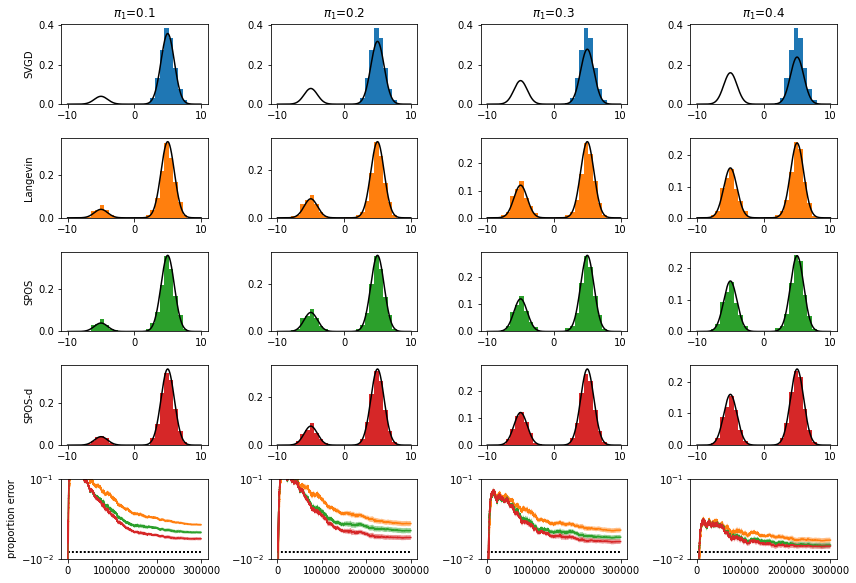

In [307]:
from run_svgd import get_dist
import os

dist="N"

grid = torch.linspace(-10,10,1000)[:,None]
fig, axes = plt.subplots(5,4, figsize=(12,8))
axes = np.atleast_2d(axes)
pis = [0.1,0.2,0.3,0.4]

alg_names = ["SVGD", "Langevin", "SPOS", "SPOS-d"]

for pii, pi in enumerate(pis):
        
    ax = axes[0, pii]

    q, p = get_dist(dist, pi, 0.0)

    for ai, alg in enumerate(["svgd", "lang", "spos_ori", "spos"]):

        all_props = []
        for seed in range(20):
        
            if alg == "svgd":
                fn = f"results/D{dist}_pi{pi}_sigma1.0_noise1.0_mean10.0_is3000_{alg}_ntfixed_seed{seed:02d}.npz"

            elif alg == "spos_ori":
                fn = f"results/D{dist}_pi{pi}_sigma1.0_noise1.0_mean10.0_is3000_spos_ntfixed_seed{seed:02d}.npz"  
            elif alg == "lang":
                fn = f"results/D{dist}_pi{pi}_sigma1.0_noise1.0_mean10.0_is3000_lang_ntdecreasing_seed{seed:02d}.npz"  
            else:
                fn = f"results/D{dist}_pi{pi}_sigma1.0_noise1.0_mean10.0_is3000_{alg}_ntdecreasing_seed{seed:02d}.npz"
        #     fn = f"results/D{dist}_pi{pi}_sigma5.0_noise5_ni500_seed00.npz"

            if not os.path.exists(fn):
                print(f"waiting for {fn}")
                continue

            globals().update(np.load(fn))
            
            all_props += props,

            if isinstance(x, torch.Tensor):
                x = x.cpu().numpy()
                
                
        pdf = p.log_prob(grid.to("cuda:0")).exp().cpu()
        true_pi = pdf[grid[:,0]<0].sum() / pdf.sum() 
        props_mean = 1 - np.mean(all_props,0) - float(true_pi) 
        props_std = np.std(all_props,0) / np.sqrt(len(all_props))

            
        ax = axes[ai, pii]
        ax.hist(x[:,0], density=True, bins=np.linspace(-10,10,30), label = alg, color=f"C{ai}")
        pt_x = p.log_prob(grid.to("cuda:0")).exp().cpu()
        ax.plot(grid.cpu(), pt_x.cpu(), "k")

        ax = axes[4, pii]       
        ax.plot(props_mean, label = alg, alpha=1.0)
        ax.fill_between(range(len(props)), props_mean+props_std, props_mean - props_std , label = alg, alpha=0.5)

        ax.hlines(0, 0, len(props), color="k", ls=":")
        ax.set_yscale("symlog")
        ax.set_ylim([-0.01,0.1])
        axes[ai,0].set_ylabel(alg_names[ai])

axes[4,0].set_ylabel("proportion error")
    
fig.tight_layout()

for pii, pi in enumerate(pis):
    axes[0, pii].set_title(f"$\pi_1$={pi}")


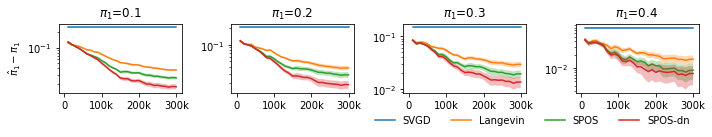

In [333]:
from run_svgd import get_dist
import os

dist="N"

grid = torch.linspace(-10,10,1000)[:,None]


fig, axes = plt.subplots(1,4, figsize=(10,1.5))
axes = np.atleast_2d(axes)
pis = [0.1,0.2,0.3,0.4]

alg_names = ["SVGD", "Langevin", "SPOS", "SPOS-dn"]

means = [0.0]

for mi, mean in enumerate(means):
    for pii, pi in enumerate(pis):
        
        q, p = get_dist(dist, pi, 0.0)

        for ai, alg in enumerate(["svgd", "lang", "spos_ori", "spos"]):

            all_props = []
            for seed in range(20):

                if alg == "svgd":
                    fn = f"results/D{dist}_pi{pi}_sigma1.0_noise1.0_mean{mean}_is3000_{alg}_ntfixed_seed{seed:02d}.npz"

                elif alg == "spos_ori":
                    fn = f"results/D{dist}_pi{pi}_sigma1.0_noise1.0_mean{mean}_is3000_spos_ntfixed_seed{seed:02d}.npz"  
                elif alg == "lang":
                    fn = f"results/D{dist}_pi{pi}_sigma1.0_noise1.0_mean{mean}_is3000_lang_ntdecreasing_seed{seed:02d}.npz"  
                else:
                    fn = f"results/D{dist}_pi{pi}_sigma1.0_noise1.0_mean{mean}_is3000_{alg}_ntdecreasing_seed{seed:02d}.npz"
            #     fn = f"results/D{dist}_pi{pi}_sigma5.0_noise5_ni500_seed00.npz"

                if not os.path.exists(fn):
                    print(f"waiting for {fn}")
                    continue

                globals().update(np.load(fn))

                all_props += props,

                if isinstance(x, torch.Tensor):
                    x = x.cpu().numpy()


            pdf = p.log_prob(grid.to("cuda:0")).exp().cpu()
            true_pi = pdf[grid[:,0]<0].sum() / pdf.sum() 
            props_mean = 1 - np.mean(all_props,0) - float(true_pi) 
            props_std = np.std(all_props,0) / np.sqrt(len(all_props))

            ax = axes[mi,pii] 
            niter = len(props)
            every = 10000
            props_mean = props_mean[every-1::every]
            props_std = props_std[every-1::every]
            ax.plot(range(every-1,niter,every), props_mean, label = alg, alpha=1.0, zorder = ai)
            ax.fill_between(range(every-1,niter,every), props_mean+props_std, props_mean - props_std , 
                            label = alg, alpha=0.3 , zorder = ai)

            ax.hlines(0, 0, len(props), color="k", ls=":")
    #         ax.set_ylim([3e-3,0.3])
            ax.set_yscale("log")
            ax.set_xticks([0,1e5,2e5,3e5])
            ax.set_xticklabels(["0","100k", "200k", "300k"])

    axes[mi,0].set_ylabel(r"$\hat\pi_1 - \pi_1$")
    
fig.tight_layout()
axes[-1,-1].legend(alg_names, loc="upper right", bbox_to_anchor=(1.0,-0.2), ncol=4, frameon=False)

for pii, pi in enumerate(pis):
    axes[0, pii].set_title(f"$\pi_1$={pi}")

fig.savefig("../../litenet/figs/spos-d.pdf", bbox_inches="tight", pad_inches=0.01)

/nfs/ghome/live/kevinli/anaconda3/envs/score_EM/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/nfs/ghome/live/kevinli/anaconda3/envs/score_EM/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/nfs/ghome/live/kevinli/anaconda3/envs/score_EM/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/nfs/ghome/live/kevinli/anaconda3/envs/score_EM/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


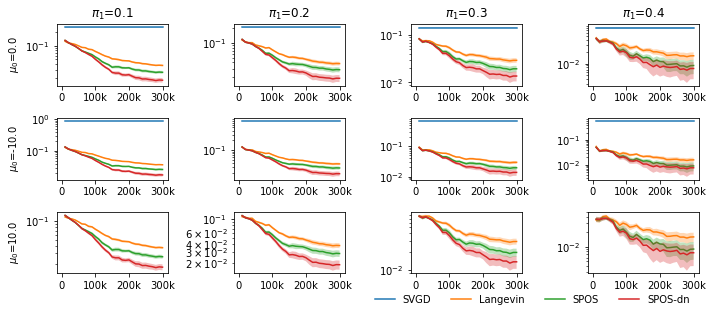

In [328]:
from run_svgd import get_dist
import os

dist="N"

grid = torch.linspace(-10,10,1000)[:,None]


fig, axes = plt.subplots(3,4, figsize=(10,4))
axes = np.atleast_2d(axes)
pis = [0.1,0.2,0.3,0.4]

alg_names = ["SVGD", "Langevin", "SPOS", "SPOS-dn"]

means = [0.0,-10.0,10.0]

for mi, mean in enumerate(means):
    for pii, pi in enumerate(pis):
        
        q, p = get_dist(dist, pi, 0.0)

        for ai, alg in enumerate(["svgd", "lang", "spos_ori", "spos"]):

            all_props = []
            for seed in range(20):

                if alg == "svgd":
                    fn = f"results/D{dist}_pi{pi}_sigma1.0_noise1.0_mean{mean}_is3000_{alg}_ntfixed_seed{seed:02d}.npz"

                elif alg == "spos_ori":
                    fn = f"results/D{dist}_pi{pi}_sigma1.0_noise1.0_mean{mean}_is3000_spos_ntfixed_seed{seed:02d}.npz"  
                elif alg == "lang":
                    fn = f"results/D{dist}_pi{pi}_sigma1.0_noise1.0_mean{mean}_is3000_lang_ntdecreasing_seed{seed:02d}.npz"  
                else:
                    fn = f"results/D{dist}_pi{pi}_sigma1.0_noise1.0_mean{mean}_is3000_{alg}_ntdecreasing_seed{seed:02d}.npz"
            #     fn = f"results/D{dist}_pi{pi}_sigma5.0_noise5_ni500_seed00.npz"

                if not os.path.exists(fn):
                    print(f"waiting for {fn}")
                    continue

                globals().update(np.load(fn))

                all_props += props,

                if isinstance(x, torch.Tensor):
                    x = x.cpu().numpy()


            pdf = p.log_prob(grid.to("cuda:0")).exp().cpu()
            true_pi = pdf[grid[:,0]<0].sum() / pdf.sum() 
            props_mean = 1 - np.mean(all_props,0) - float(true_pi) 
            props_std = np.std(all_props,0) / np.sqrt(len(all_props))

            ax = axes[mi,pii] 
            niter = len(props)
            every = 10000
            props_mean = props_mean[every-1::every]
            props_std = props_std[every-1::every]
            ax.plot(range(every-1,niter,every), props_mean, label = alg, alpha=1.0, zorder = ai)
            ax.fill_between(range(every-1,niter,every), props_mean+props_std, props_mean - props_std , 
                            label = alg, alpha=0.3 , zorder = ai)

            ax.hlines(0, 0, len(props), color="k", ls=":")
    #         ax.set_ylim([3e-3,0.3])
            ax.set_yscale("log")
            ax.set_xticks([0,1e5,2e5,3e5])
            ax.set_xticklabels(["0","100k", "200k", "300k"])

    axes[mi,0].set_ylabel(f"$\mu_0$={mean}")
    
fig.tight_layout()
axes[-1,-1].legend(alg_names, loc="upper right", bbox_to_anchor=(1.0,-0.2), ncol=4, frameon=False)

for pii, pi in enumerate(pis):
    axes[0, pii].set_title(f"$\pi_1$={pi}")

fig.savefig("../../litenet/figs/spos-d_supp.pdf", bbox_inches="tight", pad_inches=0.01)

In [ ]:
# mixture q


torch.random.manual_seed(123)
pis = torch.linspace(1e-3,0.5,11)
grid = torch.linspace(-3,3,1000)[:,None]

max_q_ksds = []
max_q_ksd_stds = []

max_p_ksds = []
max_p_ksd_stds = []

q_ksd_trues_0 = []
q_ksd_std_trues_0 = []

p_ksd_trues_0 = []
p_ksd_std_trues_0 = []


for pi in pis:
    mixing = Categorical(probs = torch.tensor([pi,1-pi]))
    component = Independent(SNormal(torch.tensor([-1.0,1.0])[:,None],torch.ones(1,1)*0.2), 1)
    q = SGMM(mixing, component, 1)


    # mixture p
    mixing = Categorical(probs = torch.tensor([0.5,0.5]))
    component = Independent(SNormal(torch.tensor([-1.0,1.0])[:,None],torch.ones(1,1)*0.2), 1)
    p = SGMM(mixing, component, 1)
    q_ksds, q_ksd_stds, p_ksds, p_ksd_stds, q_ksd_trues, q_ksd_std_trues, p_ksd_trues, p_ksd_std_trues = \
        get_noise_plot(q,p, plot=False, nsample=2000)
    
    max_idx = np.argmax(q_ksds)
    max_q_ksds += q_ksds[max_idx],
    max_q_ksd_stds += q_ksd_stds[max_idx],
    
    max_idx = np.argmax(p_ksds)
    max_p_ksds += p_ksds[max_idx],
    max_p_ksd_stds += p_ksd_stds[max_idx],
    
    
    q_ksd_trues_0 += q_ksd_trues[0],
    q_ksd_std_trues_0 += q_ksd_std_trues[0],
    
    p_ksd_trues_0 += p_ksd_trues[0],
    p_ksd_std_trues_0 += p_ksd_std_trues[0],
    
np.savez('tmKSD_mix_MoG.npz',
        max_q_ksds=max_q_ksds,
         max_q_ksd_stds = max_q_ksd_stds,
        max_p_ksds=max_p_ksds,
        max_p_ksd_stds=max_p_ksd_stds,
        q_ksd_trues_0=q_ksd_trues_0,
        q_ksd_std_trues_0=q_ksd_std_trues_0,
        p_ksd_trues_0=p_ksd_trues_0,
        p_ksd_std_trues_0=p_ksd_std_trues_0)